# Libraries

In [1]:
import os, csv, math, time, glob
import argparse
from pathlib import Path
import numpy as np
import cv2 
from tqdm import tqdm
import mediapipe as mp
from collections import Counter, defaultdict
import json
from collections import deque
import shutil
from statistics import mean, stdev
import hashlib

# Data Preprocessing

In [2]:
DATASET_DIR = r"C:\Users\Jerome\Project Design\Videos"   # root with Color/Family/Numbers
REPORT_CSV  = r"C:\Users\Jerome\Project Design\video_audit.csv"

VIDEO_EXTS = {".mp4",".avi",".mov",".mkv",".m4v",".webm",".mpg"}
SAMPLE_FRAMES_PER_VIDEO = 20

DO_CENTERING_CHECK = False
CENTER_BOX_W, CENTER_BOX_H = 1156, 866
CENTER_MARGIN_PX = 20

def iter_leaf_class_dirs(root_dir: str):
    """Yield (top, leaf, leaf_path) for folders that contain at least one video."""
    root = Path(root_dir)
    for top in sorted([p for p in root.iterdir() if p.is_dir()]):
        for leaf in sorted([p for p in top.iterdir() if p.is_dir()]):
            vids = [q for q in leaf.iterdir() if q.suffix.lower() in VIDEO_EXTS]
            if vids:
                yield (top.name, leaf.name, leaf)

# OPTIONAL centering check (pose inside centered box)
if DO_CENTERING_CHECK:
    import mediapipe as mp
    mp_pose = mp.solutions.pose
    POSE_IDXS = [0, 11, 12, 13, 14, 15, 16]  # nose, shoulders, elbows, wrists

    def pct_frames_landmarks_in_center(frame_reader, w, h):
        box_w, box_h = min(CENTER_BOX_W, w), min(CENTER_BOX_H, h)
        x0 = (w - box_w) // 2; y0 = (h - box_h) // 2
        x1, y1 = x0 + box_w, y0 + box_h
        success = total = 0
        with mp_pose.Pose(static_image_mode=False, model_complexity=0) as pose:
            for frame in frame_reader():
                total += 1
                rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                res = pose.process(rgb)
                ok = False
                if res.pose_landmarks:
                    ok = True
                    for idx in POSE_IDXS:
                        lm = res.pose_landmarks.landmark[idx]
                        x_px, y_px = lm.x * w, lm.y * h
                        if not (x0 + CENTER_MARGIN_PX <= x_px <= x1 - CENTER_MARGIN_PX and
                                y0 + CENTER_MARGIN_PX <= y_px <= y1 - CENTER_MARGIN_PX):
                            ok = False; break
                if ok: success += 1
        return (success / total * 100.0) if total else 0.0

In [3]:
rows = []
per_leaf_res = defaultdict(Counter)   # (top/leaf) -> res counts
per_leaf_fps = defaultdict(Counter)

def fourcc_to_str(v):
    try:
        return "".join([chr((int(v) >> 8 * i) & 0xFF) for i in range(4)])
    except:
        return "unknown"

leafs = list(iter_leaf_class_dirs(DATASET_DIR))
if not leafs:
    print("[warn] No leaf class folders with videos found. Check your directory structure.")

for top, leaf, leaf_path in leafs:
    videos = sorted([p for p in leaf_path.iterdir() if p.suffix.lower() in VIDEO_EXTS])
    for vp in videos:
        cap = cv2.VideoCapture(str(vp))
        if not cap.isOpened():
            print(f"[WARN] Cannot open: {vp}")
            continue

        w  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        h  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = float(cap.get(cv2.CAP_PROP_FPS) or 0.0)
        nframes = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        duration = (nframes / fps) if (fps and fps > 0) else float("nan")

        fourcc_val = cap.get(cv2.CAP_PROP_FOURCC)
        codec = fourcc_to_str(fourcc_val)

        centering_pct = ""
        if DO_CENTERING_CHECK and nframes > 0:
            idxs = sorted(set(int(i) for i in np.linspace(0, max(0, nframes-1),
                                                          num=min(SAMPLE_FRAMES_PER_VIDEO, nframes))))
            def reader():
                for idx in idxs:
                    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                    ok, frame = cap.read()
                    if ok: yield frame
            centering_pct = round(pct_frames_landmarks_in_center(reader, w, h), 2)
            cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

        cap.release()

        res_str = f"{w}x{h}"
        key = (top, leaf)
        per_leaf_res[key][res_str] += 1
        fps_round = round(float(fps), 2) if math.isfinite(fps) else 0.0
        per_leaf_fps[key][fps_round] += 1

        rows.append({
            "top_class": top,
            "leaf_class": leaf,
            "video": vp.name,
            "path": str(vp),
            "width": w,
            "height": h,
            "resolution": res_str,
            "fps": fps_round,
            "frame_count": nframes,
            "duration_sec": round(duration, 3) if math.isfinite(duration) else "",
            "codec": codec,
            "aspect_ratio": round(w / h, 5) if h else "",
            "center_check_pct_in_box": centering_pct
        })

In [4]:
os.makedirs(os.path.dirname(REPORT_CSV), exist_ok=True)
fieldnames = ["top_class","leaf_class","video","path","width","height","resolution","fps",
              "frame_count","duration_sec","codec","aspect_ratio","center_check_pct_in_box"]
with open(REPORT_CSV, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(rows)

# Summaries
print("\nUNIQUE RESOLUTIONS PER LEAF CLASS")
for key, cnt in per_leaf_res.items():
    total = sum(cnt.values())
    common, common_n = cnt.most_common(1)[0] if cnt else ("",0)
    print(f"{key[0]}/{key[1]}: {dict(cnt)} | most common = {common} ({common_n}/{total})")

print("\nUNIQUE FPS PER LEAF CLASS")
for key, cnt in per_leaf_fps.items():
    total = sum(cnt.values())
    common, common_n = cnt.most_common(1)[0] if cnt else ("",0)
    print(f"{key[0]}/{key[1]}: {dict(cnt)} | most common = {common} fps ({common_n}/{total})")

# Inconsistencies vs each leaf class's majority
print("\nINCONSISTENCIES (by leaf-class majority)")
res_major = {k: (per_leaf_res[k].most_common(1)[0][0] if per_leaf_res[k] else None) for k in per_leaf_res}
fps_major = {k: (per_leaf_fps[k].most_common(1)[0][0] if per_leaf_fps[k] else None) for k in per_leaf_fps}

bad = []
for r in rows:
    key = (r["top_class"], r["leaf_class"])
    mismatches = []
    if res_major.get(key) and r["resolution"] != res_major[key]:
        mismatches.append(f"res {r['resolution']} != {res_major[key]}")
    if fps_major.get(key) is not None and r["fps"] != fps_major[key]:
        mismatches.append(f"fps {r['fps']} != {fps_major[key]}")
    if mismatches:
        bad.append((key, r["video"], "; ".join(mismatches)))

if bad:
    for (top, leaf), vid, why in bad:
        print(f"[{top}/{leaf}] {vid}: {why}")
else:
    print("No resolution/FPS mismatches found within each leaf class.")

print(f"\nReport saved to: {REPORT_CSV}")
print(f"Rows written: {len(rows)}")
if len(rows) == 0:
    print("No videos found. Verify your folder structure and extensions.")


UNIQUE RESOLUTIONS PER LEAF CLASS
Color/Black: {'640x360': 20} | most common = 640x360 (20/20)
Color/Blue: {'640x360': 20} | most common = 640x360 (20/20)
Color/Brown: {'640x360': 20} | most common = 640x360 (20/20)
Color/Dark: {'640x360': 20} | most common = 640x360 (20/20)
Color/Gray: {'640x360': 20} | most common = 640x360 (20/20)
Color/Green: {'640x360': 21} | most common = 640x360 (21/21)
Color/Light: {'640x360': 20} | most common = 640x360 (20/20)
Color/Orange: {'640x360': 20} | most common = 640x360 (20/20)
Color/Pink: {'640x360': 20} | most common = 640x360 (20/20)
Color/Red: {'640x360': 20} | most common = 640x360 (20/20)
Color/Violet: {'640x360': 20} | most common = 640x360 (20/20)
Color/White: {'640x360': 20} | most common = 640x360 (20/20)
Color/Yellow: {'640x360': 20} | most common = 640x360 (20/20)
Family/Auntie: {'640x360': 20} | most common = 640x360 (20/20)
Family/Cousin: {'640x360': 21} | most common = 640x360 (21/21)
Family/Daughter: {'640x360': 20} | most common = 

As can be seen, every video has the same resolution of 640x360 pixels and their frames per second is 60 fps. This verifications means that our data is clean and be extracted. Their duration is also 4.067 per video with frame count of 244. 


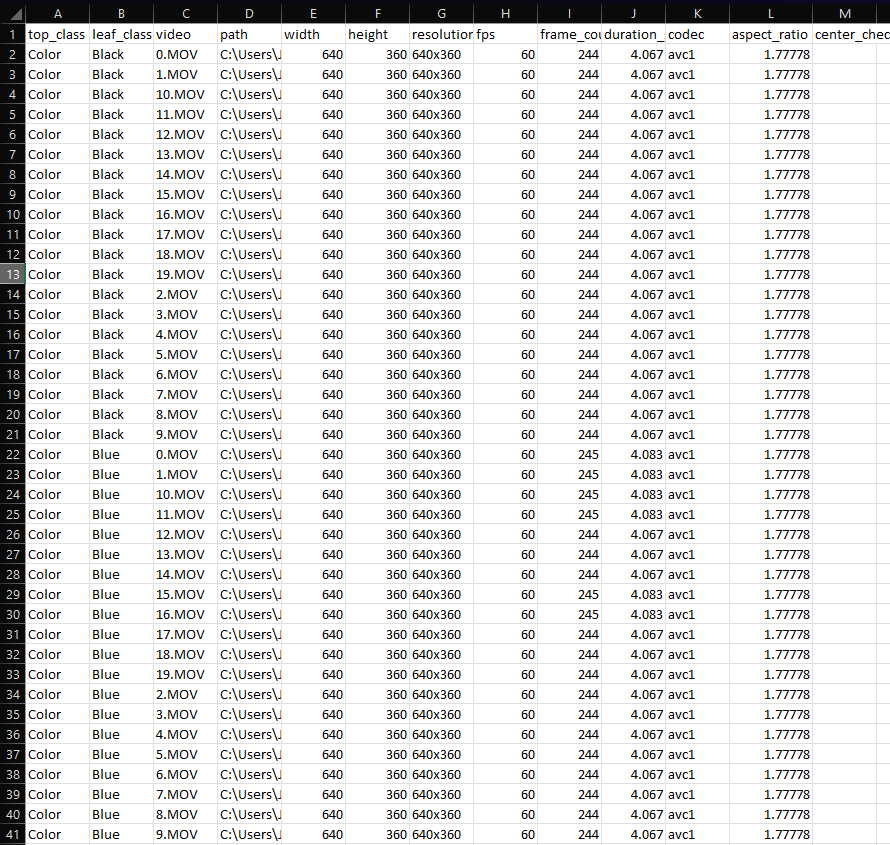

In [5]:
DATASET_DIR   = r"C:\Users\Jerome\Project Design\Videos"
VIDEO_EXTS    = (".mp4",".avi",".mov",".mkv",".m4v",".webm",".mpg")
SAMPLE_FRAMES = 12
HASH_THUMB    = (64, 36)

def iter_leaf_class_dirs(root_dir: str):
    root = Path(root_dir)
    for top in sorted([p for p in root.iterdir() if p.is_dir()]):
        for leaf in sorted([p for p in top.iterdir() if p.is_dir()]):
            vids = [q for q in leaf.iterdir() if q.suffix.lower() in VIDEO_EXTS]
            if vids:
                yield (f"{top.name}/{leaf.name}", leaf, vids)

def iter_sample_indices(nframes, k):
    if nframes <= 0 or k <= 0: return []
    return sorted(set(int(i) for i in np.linspace(0, max(0, nframes-1), num=min(k, nframes))))

def content_signature(cap, idxs, thumb=HASH_THUMB):
    hs = []
    for idx in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ok, frame = cap.read()
        if not ok: continue
        g = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        g = cv2.resize(g, thumb, interpolation=cv2.INTER_AREA)
        hs.append(hashlib.sha1(g.tobytes()).hexdigest())
    return hashlib.sha1(("|".join(hs)).encode("utf-8")).hexdigest() if hs else ""

records = []
sig_buckets = defaultdict(list)  # sig -> list of idx in records

leafs = list(iter_leaf_class_dirs(DATASET_DIR))
print("Results")
print(f"Scanned leaf classes: {len(leafs)}")

for label, leaf_dir, vids in leafs:
    for vf in sorted(vids):
        path = str(vf)
        rec = dict(label=label, video=vf.name, path=path, status="OK", reason="")
        cap = cv2.VideoCapture(path)
        if not cap.isOpened():
            rec["status"] = "UNREADABLE"; rec["reason"] = "cannot_open"
            records.append(rec); continue

        w  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        h  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = float(cap.get(cv2.CAP_PROP_FPS) or 0.0)
        nframes = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        dur = (nframes / fps) if (fps and fps > 0) else float("nan")

        invalid = []
        if w <= 0 or h <= 0: invalid.append("non_positive_resolution")
        if not math.isfinite(fps) or fps <= 0: invalid.append("invalid_fps")
        if not math.isfinite(dur) or dur <= 0: invalid.append("invalid_duration")
        if nframes <= 0: invalid.append("non_positive_frame_count")

        idxs = iter_sample_indices(nframes, SAMPLE_FRAMES)
        sig = content_signature(cap, idxs)
        cap.release()

        rec.update(width=w, height=h, fps=fps, frames=nframes, duration=dur, sig=sig)
        if invalid:
            rec["status"] = "INVALID_META"; rec["reason"] = ";".join(invalid)
        records.append(rec)
        if sig:
            sig_buckets[sig].append(len(records)-1)

# collect problems
unreadable = [(r["label"], r["video"], r["reason"]) for r in records if r["status"]=="UNREADABLE"]
invalid    = [(r["label"], r["video"], r["reason"]) for r in records if r["status"]=="INVALID_META"]
duplicates = []
for sig, idxs in sig_buckets.items():
    if sig and len(idxs) > 1:
        ref = records[idxs[0]]["video"]
        for j in idxs[1:]:
            r = records[j]
            duplicates.append((r["label"], r["video"], f"same_content_as={ref}"))

def print_list(title, lst):
    if not lst:
        print(f"{title}: none"); return
    print(f"{title}: {len(lst)}")
    for label, vid, why in lst:
        print(f"  [{label}] {vid} -> {why}")

print(f"Total videos: {len(records)}")
print_list("Unreadable files", unreadable)
print_list("Invalid/NaN metadata", invalid)
print_list("Duplicate videos", duplicates)
print("Done.")

Results
Scanned leaf classes: 33
Total videos: 652
Unreadable files: none
Invalid/NaN metadata: none
Duplicate videos: 1
  [Family/Grandmother] 9.MOV -> same_content_as=9.MOV
Done.


# MediaPipe Holistic 

In [6]:
DATASET_DIR = r"C:\Users\Jerome\Project Design\Videos"    # per-class folders
OUTPUT_DIR  = r"C:\Users\Jerome\Project Design\KEYPOINTS" # per-video .npy
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Auto-discover classes from folder names
actions = sorted([d for d in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, d))])

# Sequence / feature settings
SEQUENCE_LENGTH = 48  # frames per sequence
APPEND_FLAGS    = True  
SELECT_JOINTS = [0, 4, 8, 12, 16, 20]  
DERIVED_PER_JOINT = 5   
DERIVED_DIM = len(SELECT_JOINTS) * 2 * DERIVED_PER_JOINT  
BASE_HAND_DIM  = 42 * 3
FEATURE_DIM    = BASE_HAND_DIM + DERIVED_DIM + (2 if APPEND_FLAGS else 0)

# Extraction behavior
USE_HANDS_ONLY     = False  # use Holistic (hands + pose/face anchors)
MIN_DET_CONF       = 0.55
MIN_TRACK_CONF     = 0.55
MODEL_COMPLEXITY   = 2
FRAME_STRIDE       = 2
MIN_PALM_SCALE     = 0.02
CLIP_COORD         = 5.0
MAX_CARRY_FRAMES   = 3
CARRY_NOISE_STD    = 0.0
SKIP_EMPTY_VIDS    = True
MIN_DET_RATIO      = 0.10
OVERWRITE          = True
INVERT_HANDEDNESS  = True
np.random.seed(42)

# Face / pose anchor indices (MediaPipe)
FACE_IDXS = {
    "nose": 1, "forehead": 10, "lip_u": 13, "lip_l": 14,
    "brow_r": 65, "brow_l": 295, "chin": 152
}
POSE_IDXS = {"L_SH": 11, "R_SH": 12}  # shoulders

In [ ]:
FEATURE_COORDS = BASE_HAND_DIM             
DERIVED_START  = FEATURE_COORDS
DERIVED_END    = FEATURE_COORDS + DERIVED_DIM

def normalize_hand(pts: np.ndarray) -> np.ndarray: # 
    if pts is None or pts.shape != (21,3):
        return np.zeros((21,3), np.float32)
    wrist, mid = pts[0], pts[9]
    scale = float(np.linalg.norm(mid[:2] - wrist[:2]))
    if not np.isfinite(scale) or scale < MIN_PALM_SCALE:
        scale = MIN_PALM_SCALE
    out = (pts - wrist) / scale
    return np.clip(out, -CLIP_COORD, CLIP_COORD).astype(np.float32)

def normalize_global(L_pts, R_pts, anchors):
    if anchors is None or ("L_SH" not in anchors) or ("R_SH" not in anchors):
        return normalize_hand(L_pts), normalize_hand(R_pts)

    C = (anchors["L_SH"] + anchors["R_SH"]) / 2.0
    scale = np.linalg.norm((anchors["L_SH"] - anchors["R_SH"])[:2])
    if not np.isfinite(scale) or scale < 1e-6:
        scale = 1e-6

    def _norm(pts):
        if pts is None or pts.shape != (21,3):
            return np.zeros((21,3), np.float32)
        out = (pts - C) / scale
        return np.clip(out, -CLIP_COORD, CLIP_COORD).astype(np.float32)

    return _norm(L_pts), _norm(R_pts)

def derived_altitude_features(L, R, anchors):
    out = []
    if (anchors is None) or ("nose" not in anchors) or ("chin" not in anchors) \
       or ("forehead" not in anchors) or ("lip_u" not in anchors) \
       or ("brow_r" not in anchors) or ("brow_l" not in anchors):
        return np.zeros((DERIVED_DIM,), np.float32)

    brow_y = 0.5 * (anchors["brow_r"][1] + anchors["brow_l"][1])
    for H in (L, R):
        for j in SELECT_JOINTS:
            p = H[j]
            dy_chin  = p[1] - anchors["chin"][1]
            dy_lipU  = p[1] - anchors["lip_u"][1]
            dy_brow  = p[1] - brow_y
            dy_fore  = p[1] - anchors["forehead"][1]
            dz_nose  = p[2] - anchors["nose"][2]
            out.extend([dy_chin, dy_lipU, dy_brow, dy_fore, dz_nose])
    return np.asarray(out, np.float32)

def pack_feature_with_anchors(L_pts, R_pts, lf, rf, anchors) -> np.ndarray:
    Lg, Rg = normalize_global(L_pts, R_pts, anchors)
    feat = np.concatenate([Lg.reshape(-1), Rg.reshape(-1)], axis=0) 
    d = derived_altitude_features(Lg, Rg, anchors)                  
    feat = np.concatenate([feat, d], axis=0)
    if APPEND_FLAGS:
        feat = np.concatenate([feat, np.array([lf, rf], dtype=np.float32)], axis=0)
    return feat.astype(np.float32)

def split_coords_derived_flags(seq: np.ndarray):
    T, D = seq.shape
    coords  = seq[:, :FEATURE_COORDS].reshape(T, 42, 3).astype(np.float32)
    derived = np.zeros((T, DERIVED_DIM), np.float32)
    flags   = np.zeros((T, 2), np.float32)

    if D >= (FEATURE_COORDS + DERIVED_DIM + (2 if APPEND_FLAGS else 0)):
        derived = seq[:, DERIVED_START:DERIVED_END].astype(np.float32)
        if APPEND_FLAGS:
            flags = seq[:, -2:].astype(np.float32)
    elif APPEND_FLAGS and D >= (FEATURE_COORDS + 2):
        flags = seq[:, -2:].astype(np.float32)
    return coords, derived, flags

def combine_coords_derived_flags(coords: np.ndarray, derived: np.ndarray, flags: np.ndarray):
    T = coords.shape[0]
    out = coords.reshape(T, FEATURE_COORDS).astype(np.float32)
    out = np.concatenate([out, derived.astype(np.float32)], axis=1)
    if APPEND_FLAGS:
        out = np.concatenate([out, flags.astype(np.float32)], axis=1)
    return out.astype(np.float32)

def resample_to_length(coords: np.ndarray, flags: np.ndarray, target_len: int):
    T = coords.shape[0]
    if T == target_len:
        return coords.astype(np.float32), flags.astype(np.float32)
    idx = np.linspace(0, T - 1, num=target_len)
    lo = np.floor(idx).astype(int)
    hi = np.clip(lo + 1, 0, T - 1)
    w  = (idx - lo)[:, None, None]
    coords_out = (1 - w) * coords[lo] + w * coords[hi]
    flags_out  = flags[np.round(idx).astype(int)]
    return coords_out.astype(np.float32), flags_out.astype(np.float32)

def resample_to_length_vec(X: np.ndarray, target_len: int):
    T = X.shape[0]
    if T == target_len:
        return X.astype(np.float32)
    idx = np.linspace(0, T - 1, num=target_len)
    lo = np.floor(idx).astype(int)
    hi = np.clip(lo + 1, 0, T - 1)
    w  = (idx - lo)[:, None]
    X_out = (1 - w) * X[lo] + w * X[hi]
    return X_out.astype(np.float32)

In [ ]:
def _motion_mag(coords: np.ndarray) -> np.ndarray:
    v = np.diff(coords, axis=0)
    return np.linalg.norm(v, axis=(1, 2))

def _tail_is_frozen(coords: np.ndarray, k=6, eps=5e-4) -> bool:
    k = min(k, coords.shape[0]-1) if coords.shape[0] > 1 else 1
    tail = coords[-(k+1):]
    diffs = np.abs(np.diff(tail, axis=0)).mean()
    return bool(diffs < eps)

def _defrost_tail(coords: np.ndarray, strength=0.25):
    T = coords.shape[0]
    if T < 4:
        return coords
    seg = max(3, int(T * strength))
    a0 = T - seg
    a1 = T - 1
    if a0 >= a1:
        return coords
    ramp = np.linspace(0.0, 1.0, seg, dtype=np.float32)[:, None, None]
    mid0, mid1 = max(0, T//3), min(T-1, 2*T//3)
    mean_v = (coords[mid1] - coords[mid0]) / max(1, (mid1 - mid0))
    coords[a0:T] = coords[a0:T] + 0.02 * ramp * mean_v
    return coords

def _sliding_best_window(score: np.ndarray, win: int):
    win = max(1, min(win, len(score)))
    c = np.r_[0.0, np.cumsum(score, dtype=np.float64)]
    sums = c[win:] - c[:-win]
    j = int(np.argmax(sums))
    return j, j + win

def _norm01(x: np.ndarray, eps=1e-8):
    if x.size == 0:
        return x
    lo, hi = float(x.min()), float(x.max())
    if not np.isfinite(lo) or not np.isfinite(hi) or (hi - lo) < eps:
        return np.zeros_like(x, dtype=np.float32)
    return ((x - lo) / (hi - lo)).astype(np.float32)

def temporal_fix(seq: np.ndarray, target_len: int) -> np.ndarray:
    PAD_HEAD, PAD_TAIL = 5, 5 

    coords, derived, flags = split_coords_derived_flags(seq)  # (T,42,3),(T,DERIVED_DIM),(T,2)
    T = coords.shape[0]
    if T == 0:
        return seq.astype(np.float32)

    v = np.diff(coords, axis=0)
    motion = np.linalg.norm(v, axis=(1,2))
    motion = np.r_[motion[:1], motion]  # length T
    det = (flags.sum(axis=1) > 0.5).astype(np.float32)

    def _norm01(x, eps=1e-8):
        if x.size == 0: return x
        lo, hi = float(x.min()), float(x.max())
        if not np.isfinite(lo) or not np.isfinite(hi) or (hi - lo) < eps:
            return np.zeros_like(x, dtype=np.float32)
        return ((x - lo) / (hi - lo)).astype(np.float32)

    m_norm = _norm01(motion)
    score = 0.7*m_norm + 0.3*det

    CORE_LEN = max(8, target_len - (PAD_HEAD + PAD_TAIL))

    def _sliding_best_window(s, win):
        win = max(1, min(win, len(s)))
        c = np.r_[0.0, np.cumsum(s, dtype=np.float64)]
        sums = c[win:] - c[:-win]
        j = int(np.argmax(sums))
        return j, j + win

    start, end = _sliding_best_window(score, min(CORE_LEN, T))
    win_coords  = coords[start:end]
    win_derived = derived[start:end]
    win_flags   = flags[start:end]

    if win_coords.shape[0] >= 2:
        v_loc   = np.diff(win_coords, axis=0)
        mot_loc = np.linalg.norm(v_loc, axis=(1,2))
        mot_loc = np.r_[mot_loc[:1], mot_loc]
        m_loc   = _norm01(mot_loc)
        det_loc = (win_flags.sum(axis=1) > 0.5).astype(np.float32)

        eps_onset, k = 0.08, 2
        active = (m_loc > eps_onset) & (det_loc > 0.5)
        onset_idx, run = 0, 0
        for i, a in enumerate(active):
            run = run + 1 if a else 0
            if run >= k:
                onset_idx = i - k + 1
                break
        if 0 < onset_idx < win_coords.shape[0]-1:
            win_coords  = win_coords[onset_idx:]
            win_derived = win_derived[onset_idx:]
            win_flags   = win_flags[onset_idx:]

    core_coords, core_flags = resample_to_length(win_coords, win_flags, CORE_LEN)
    core_derived = resample_to_length_vec(win_derived, CORE_LEN)

    head_coords  = np.zeros((PAD_HEAD, 42, 3),       np.float32)
    head_derived = np.zeros((PAD_HEAD, DERIVED_DIM), np.float32)
    head_flags   = np.zeros((PAD_HEAD, 2),           np.float32)

    if PAD_TAIL > 0:
        last_c = core_coords[-1:].copy()
        last_d = core_derived[-1:].copy()
        alphas = np.linspace(1.0 - 1.0/max(1,PAD_TAIL), 0.0, num=PAD_TAIL, dtype=np.float32)
        tail_coords  = np.repeat(last_c, PAD_TAIL, axis=0) * alphas[:, None, None]
        tail_derived = np.repeat(last_d, PAD_TAIL, axis=0) * alphas[:, None]
        tail_flags   = np.zeros((PAD_TAIL, 2), np.float32)   # <- ALL ZERO so viz hides entire tail
    else:
        tail_coords  = np.empty((0,42,3), np.float32)
        tail_derived = np.empty((0,DERIVED_DIM), np.float32)
        tail_flags   = np.empty((0,2), np.float32)

    out_coords  = np.concatenate([head_coords,  core_coords,  tail_coords],  axis=0)
    out_derived = np.concatenate([head_derived, core_derived, tail_derived], axis=0)
    out_flags   = np.concatenate([head_flags,   core_flags,   tail_flags],   axis=0)

    if out_coords.shape[0] != target_len:
        need = target_len - out_coords.shape[0]
        if need > 0:
            zc = np.zeros((need, 42, 3),       np.float32)
            zd = np.zeros((need, DERIVED_DIM), np.float32)
            zf = np.zeros((need, 2),           np.float32)
            out_coords  = np.concatenate([out_coords,  zc], axis=0)
            out_derived = np.concatenate([out_derived, zd], axis=0)
            out_flags   = np.concatenate([out_flags,   zf], axis=0)
        else:
            out_coords  = out_coords[:target_len]
            out_derived = out_derived[:target_len]
            out_flags   = out_flags[:target_len]

    return combine_coords_derived_flags(out_coords, out_derived, out_flags).astype(np.float32)

In [ ]:
mp_hands    = mp.solutions.hands
mp_holistic = mp.solutions.holistic

def get_detector():
    if USE_HANDS_ONLY:
        return mp_hands.Hands(static_image_mode=False,
                              max_num_hands=2,
                              model_complexity=MODEL_COMPLEXITY,
                              min_detection_confidence=MIN_DET_CONF,
                              min_tracking_confidence=MIN_TRACK_CONF)
    else:
        return mp_holistic.Holistic(static_image_mode=False,
                                    model_complexity=MODEL_COMPLEXITY,
                                    smooth_landmarks=True,
                                    refine_face_landmarks=False,
                                    min_detection_confidence=MIN_DET_CONF,
                                    min_tracking_confidence=MIN_TRACK_CONF,
                                    enable_segmentation=False)

def get_lr_pts(res, use_hands_only=True):
    if res is None:
        return None, None

    if use_hands_only:
        if not getattr(res, "multi_hand_landmarks", None):
            return None, None

        L, R = None, None
        handed = getattr(res, "multi_handedness", None)

        if handed and len(handed) == len(res.multi_hand_landmarks):
            for lm, hd in zip(res.multi_hand_landmarks, handed):
                label = hd.classification[0].label if hd.classification else "Right"
                if INVERT_HANDEDNESS:
                    label = "Left" if label == "Right" else "Right"
                pts = np.array([[p.x, p.y, p.z] for p in lm.landmark], dtype=np.float32)
                if label == "Left": L = pts
                else: R = pts
        else:
            lms = res.multi_hand_landmarks
            if len(lms) >= 1:
                pts0 = np.array([[p.x, p.y, p.z] for p in lms[0].landmark], dtype=np.float32)
                if INVERT_HANDEDNESS: L = pts0
                else: R = pts0
            if len(lms) >= 2:
                pts1 = np.array([[p.x, p.y, p.z] for p in lms[1].landmark], dtype=np.float32)
                if INVERT_HANDEDNESS: R = pts1
                else: L = pts1
        return L, R

    L = (np.array([[lm.x, lm.y, lm.z] for lm in res.left_hand_landmarks.landmark], dtype=np.float32)
         if getattr(res, "left_hand_landmarks", None) else None)
    R = (np.array([[lm.x, lm.y, lm.z] for lm in res.right_hand_landmarks.landmark], dtype=np.float32)
         if getattr(res, "right_hand_landmarks", None) else None)

    if INVERT_HANDEDNESS:
        L, R = R, L
    return L, R

def get_anchors(res):
    anchors = {}
    # pose shoulders are required for global norm
    if getattr(res, "pose_landmarks", None):
        L = res.pose_landmarks.landmark[POSE_IDXS["L_SH"]]
        R = res.pose_landmarks.landmark[POSE_IDXS["R_SH"]]
        anchors["L_SH"] = np.array([L.x, L.y, L.z], np.float32)
        anchors["R_SH"] = np.array([R.x, R.y, R.z], np.float32)
    else:
        return None

    if getattr(res, "face_landmarks", None):
        fl = res.face_landmarks.landmark
        anchors["nose"]     = np.array([fl[FACE_IDXS["nose"]].x,     fl[FACE_IDXS["nose"]].y,     fl[FACE_IDXS["nose"]].z], np.float32)
        anchors["forehead"] = np.array([fl[FACE_IDXS["forehead"]].x, fl[FACE_IDXS["forehead"]].y, fl[FACE_IDXS["forehead"]].z], np.float32)
        anchors["lip_u"]    = np.array([fl[FACE_IDXS["lip_u"]].x,    fl[FACE_IDXS["lip_u"]].y,    fl[FACE_IDXS["lip_u"]].z], np.float32)
        anchors["lip_l"]    = np.array([fl[FACE_IDXS["lip_l"]].x,    fl[FACE_IDXS["lip_l"]].y,    fl[FACE_IDXS["lip_l"]].z], np.float32)
        anchors["brow_r"]   = np.array([fl[FACE_IDXS["brow_r"]].x,   fl[FACE_IDXS["brow_r"]].y,   fl[FACE_IDXS["brow_r"]].z], np.float32)
        anchors["brow_l"]   = np.array([fl[FACE_IDXS["brow_l"]].x,   fl[FACE_IDXS["brow_l"]].y,   fl[FACE_IDXS["brow_l"]].z], np.float32)
        anchors["chin"]     = np.array([fl[FACE_IDXS["chin"]].x,     fl[FACE_IDXS["chin"]].y,     fl[FACE_IDXS["chin"]].z], np.float32)
    return anchors

In [ ]:
try:
    MAX_CARRY_FRAMES
except NameError:
    MAX_CARRY_FRAMES = min(4, SEQUENCE_LENGTH // 6)  # avoid long frozen repeats

try:
    CARRY_NOISE_STD
except NameError:
    CARRY_NOISE_STD = 0.003  # tiny jitter on coords when carrying last obs

VIDEO_EXTS = (".mp4",".avi",".mov",".mkv",".mpg",".m4v",".webm")

def iter_leaf_class_dirs(root_dir: str):
    root = Path(root_dir)
    for top in sorted([p for p in root.iterdir() if p.is_dir()]):
        for leaf in sorted([p for p in top.iterdir() if p.is_dir()]):
            vids = [q for q in leaf.iterdir() if q.suffix.lower() in VIDEO_EXTS]
            if vids:
                label = f"{top.name}_{leaf.name}"  # e.g., Color_Black
                yield (label, leaf)

# Build leaf class list
leaf_classes = list(iter_leaf_class_dirs(DATASET_DIR))
if not leaf_classes:
    print("[warn] No leaf class folders with videos found. Check your directory structure.")
else:
    print(f"Found {len(leaf_classes)} leaf classes with videos.")

# Main loop
for label, src_dir in leaf_classes:
    dst_dir = Path(OUTPUT_DIR, label)
    dst_dir.mkdir(parents=True, exist_ok=True)

    videos = sorted([p for p in src_dir.iterdir() if p.suffix.lower() in VIDEO_EXTS])

    with get_detector() as detector:
        from tqdm import tqdm
        for vp in tqdm(videos, desc=label):
            out_npy = dst_dir / f"{vp.stem}.npy"
            if not OVERWRITE and out_npy.exists():
                continue

            cap = cv2.VideoCapture(str(vp))
            if not cap.isOpened():
                print(f"[skip] cannot open {vp.name}")
                continue

            total_est = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or -1
            if total_est == 1:
                print(f"[warn] {vp.name}: decoder reports 1 frame; consider re-encoding to MP4 (H.264, 30fps).")
            local_stride = FRAME_STRIDE if (total_est < 0 or total_est >= SEQUENCE_LENGTH) else 1

            seq = []
            det_frames = 0
            last_obs_feat = None
            carry_count = 0
            idx = 0

            vid_frames = 0
            vid_processed = 0

            while True:
                ok, frame = cap.read()
                if not ok:
                    break
                vid_frames += 1

                if (idx % local_stride) != 0:
                    idx += 1
                    continue
                idx += 1

                rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                rgb.flags.writeable = False

                try:
                    res = detector.process(rgb)
                except Exception:
                    res = None

                L_pts, R_pts, anchors = (None, None, None)
                if res is not None:
                    try:
                        L_pts, R_pts = get_lr_pts(res, use_hands_only=USE_HANDS_ONLY)
                        anchors = get_anchors(res) if not USE_HANDS_ONLY else None
                    except Exception:
                        L_pts, R_pts, anchors = (None, None, None)

                lf = 1.0 if L_pts is not None else 0.0
                rf = 1.0 if R_pts is not None else 0.0
                detected = (lf + rf) > 0.0

                if detected:
                    feat = pack_feature_with_anchors(L_pts, R_pts, lf, rf, anchors)
                    last_obs_feat = feat
                    carry_count = 0
                    det_frames += 1
                else:
                    if (last_obs_feat is not None) and (carry_count < MAX_CARRY_FRAMES):
                        feat = last_obs_feat.copy()
                        if CARRY_NOISE_STD > 0:
                            noise = np.zeros_like(feat, dtype=np.float32)
                            noise[:BASE_HAND_DIM + DERIVED_DIM] = np.random.normal(
                                0.0, CARRY_NOISE_STD, size=BASE_HAND_DIM + DERIVED_DIM
                            ).astype(np.float32)
                            feat += noise
                        carry_count += 1
                    else:
                        feat = np.zeros((FEATURE_DIM,), dtype=np.float32)

                seq.append(feat)
                vid_processed += 1  

            cap.release()

            if len(seq) == 0:
                if SKIP_EMPTY_VIDS:
                    print(f"[skip] zero frames: {vp.name}")
                    continue

            det_ratio = det_frames / max(1, len(seq))
            if SKIP_EMPTY_VIDS and det_ratio < MIN_DET_RATIO:
                print(f"[skip] low detections {det_frames}/{len(seq)} ({det_ratio:.0%}): {vp.name}")
                continue

            seq = np.asarray(seq, dtype=np.float32)

            seq_fixed = temporal_fix(seq, SEQUENCE_LENGTH)

            if not np.count_nonzero(seq_fixed):
                if SKIP_EMPTY_VIDS:
                    print(f"[skip] all-zero after temporal_fix: {vp.name}")
                    continue

            np.save(str(out_npy), seq_fixed.astype(np.float32))

print("\nExtraction finished.")

Found 33 leaf classes with videos.

Numbers_Two: 100%|██████████| 20/20 [03:51<00:00, 11.58s/it]


Extraction finished.


In [ ]:
import glob, numpy as np
files = glob.glob(r"C:\Users\Jerome\Project Design\KEYPOINTS\**\*.npy", recursive=True)
print("files:", len(files))
a = np.load(files[0])
print("shape:", a.shape)           
print("derived_nonzero:", a[:,126:186].any())  


files: 657
shape: (48, 188)
derived_nonzero: True


# Verification

In [ ]:
DATASET_DIR = Path(r"C:\Users\Jerome\Project Design\Videos")     # raw videos per class
NPY_DIR     = Path(r"C:\Users\Jerome\Project Design\KEYPOINTS")  # extracted npy per class
VIZ_DIR     = Path(r"C:\Users\Jerome\Project Design\VIZ")        # output visualizations
VIZ_DIR.mkdir(parents=True, exist_ok=True)

ACTIONS        = None              
SOURCE_MODE    = "npy"       
VIDEO_EXTS     = {".mp4",".avi",".mov",".mkv",".mpg",".m4v",".webm"}

INPUT_DURATION_SEC = 4.0           # 4s clips -> playback fps = T/4
CANVAS_W, CANVAS_H = 1080, 1080
MARGIN   = 40
POINT_R  = 4
THICK    = 2
FONT     = cv2.FONT_HERSHEY_SIMPLEX

SAVE_MP4       = True              
PREVIEW        = False            
OVERWRITE_VIZ  = True             
HAND_CONNECTIONS = [
    (0,1),(1,2),(2,3),(3,4),        # Thumb
    (0,5),(5,6),(6,7),(7,8),        # Index
    (5,9),(9,10),(10,11),(11,12),   # Middle
    (9,13),(13,14),(14,15),(15,16), # Ring
    (13,17),(17,18),(18,19),(19,20),# Pinky
    (0,17)                          # Wrist to pinky base (optional)
]

def split_coords_flags(arr: np.ndarray):
    T, D = arr.shape
    coords = arr[:, :BASE_HAND_DIM].reshape(T, 42, 3)  # only the 42x3 hand coords
    flags  = arr[:, -2:] if APPEND_FLAGS and D >= (BASE_HAND_DIM + 2) else np.zeros((T, 2), dtype=np.float32)
    return coords.astype(np.float32), flags.astype(np.float32)

def _minmax_xy(coords):
    xy = coords[..., :2].reshape(-1, 2)
    mask = ~(np.isclose(xy[:,0], 0.0) & np.isclose(xy[:,1], 0.0))
    xy = xy[mask]
    if xy.size == 0:
        return -1.0, 1.0, -1.0, 1.0
    return xy[:,0].min(), xy[:,0].max(), xy[:,1].min(), xy[:,1].max()

def _project(ptx, pty, x0, y0, scale):
    px = int(x0 + ptx * scale)
    py = int(y0 + pty * scale)
    return px, py

def draw_hand(img, pts21, color, x0, y0, scale):
    if pts21 is None: return
    if np.allclose(pts21, 0.0): return
    for a, b in HAND_CONNECTIONS:
        ax, ay = _project(pts21[a,0], pts21[a,1], x0, y0, scale)
        bx, by = _project(pts21[b,0], pts21[b,1], x0, y0, scale)
        cv2.line(img, (ax, ay), (bx, by), color, THICK, cv2.LINE_AA)
    for i in range(21):
        px, py = _project(pts21[i,0], pts21[i,1], x0, y0, scale)
        cv2.circle(img, (px, py), POINT_R, color, -1, cv2.LINE_AA)

def make_frame(img, t, T, left_on, right_on):
    txt = f"Frame {t+1}/{T} | Left:{'Y' if left_on else 'N'}  Right:{'Y' if right_on else 'N'}"
    cv2.putText(img, txt, (16, 30), FONT, 0.8, (255,255,255), 2, cv2.LINE_AA)
    # simple time bar
    bar_h = 20
    bar_y0 = CANVAS_H - bar_h - 10
    bar_y1 = CANVAS_H - 10
    cv2.rectangle(img, (MARGIN, bar_y0), (CANVAS_W - MARGIN, bar_y1), (50,50,50), -1)
    x0 = MARGIN; x1 = CANVAS_W - MARGIN
    xpos = int(x0 + (x1 - x0) * (t / max(1, T-1)))
    cv2.line(img, (xpos, bar_y0), (xpos, bar_y1), (255,255,255), 2, cv2.LINE_AA)

def render_npy_to_mp4(npy_path: Path, out_mp4_path: Path):
    arr = np.load(str(npy_path)).astype(np.float32)
    coords, flags = split_coords_flags(arr)    # (T,42,3), (T,2)
    T = coords.shape[0]
    L = coords[:, :21, :]
    R = coords[:, 21:, :]

    # canvas scaling based on data spread
    xmin, xmax, ymin, ymax = _minmax_xy(coords)
    dx = max(1e-6, xmax - xmin)
    dy = max(1e-6, ymax - ymin)
    scale_x = (CANVAS_W - 2*MARGIN) / dx
    scale_y = (CANVAS_H - 2*MARGIN) / dy
    scale = 0.9 * min(scale_x, scale_y)
    cx, cy = CANVAS_W // 2, CANVAS_H // 2

    play_fps = T / max(1e-6, INPUT_DURATION_SEC)

    writer = None
    if SAVE_MP4:
        out_mp4_path.parent.mkdir(parents=True, exist_ok=True)
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        writer = cv2.VideoWriter(str(out_mp4_path), fourcc, play_fps, (CANVAS_W, CANVAS_H))

    if PREVIEW:
        cv2.namedWindow("NPY Visualization", cv2.WINDOW_NORMAL)
        cv2.resizeWindow("NPY Visualization", 900, 900)

    for t in range(T):
        img = np.zeros((CANVAS_H, CANVAS_W, 3), dtype=np.uint8)
        left_on  = bool(flags[t,0] > 0.5)
        right_on = bool(flags[t,1] > 0.5)

        draw_hand(img, L[t], (255,255,0),  cx, cy, scale)   # Left  = cyan
        draw_hand(img, R[t], (0,165,255), cx, cy, scale)    # Right = orange
        make_frame(img, t, T, left_on, right_on)
        cv2.putText(img, "Left = cyan, Right = orange (normalized wrist-centered coords)",
                    (16, CANVAS_H-40), FONT, 0.6, (200,200,200), 1, cv2.LINE_AA)

        if writer is not None:
            writer.write(img)
        if PREVIEW:
            cv2.imshow("NPY Visualization", img)
            key = cv2.waitKey(max(1, int(1000 / max(1, int(round(play_fps)))))) & 0xFF
            if key == 27:  # ESC
                break

    if writer is not None:
        writer.release()
    if PREVIEW:
        cv2.destroyAllWindows()

[Numbers_Two] render (npy): 100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


Done. Saved visualizations to: C:\Users\Jerome\Project Design\VIZ
  rendered:       657
  skipped exists: 0  (OVERWRITE_VIZ=True)
  missing npy:    0
  errors:         0


In [ ]:
if ACTIONS is None:
    ACTIONS = sorted([d.name for d in DATASET_DIR.iterdir() if d.is_dir()])

total_done, total_missing, total_errors, total_skipped = 0, 0, 0, 0

if SOURCE_MODE == "videos":
    for cls in ACTIONS:
        src_cls_dir = DATASET_DIR / cls
        if not src_cls_dir.is_dir():
            print(f"[warn] class missing in Videos: {src_cls_dir}")
            continue

        npy_cls_dir = NPY_DIR / cls
        viz_cls_dir = VIZ_DIR / cls
        viz_cls_dir.mkdir(parents=True, exist_ok=True)

        vids = sorted([p for p in src_cls_dir.iterdir() if p.suffix.lower() in VIDEO_EXTS])
        for vp in tqdm(vids, desc=f"[{cls}] render (videos)"):
            stem = vp.stem
            npy_path = npy_cls_dir / f"{stem}.npy"
            if not npy_path.exists():
                print(f"[skip] missing npy for video: {cls}/{vp.name} -> expected {npy_path.name}")
                total_missing += 1
                continue

            out_mp4 = viz_cls_dir / f"{stem}_viz.mp4"
            if out_mp4.exists() and not OVERWRITE_VIZ:
                total_skipped += 1
                continue

            try:
                render_npy_to_mp4(npy_path, out_mp4)
                total_done += 1
            except Exception as e:
                print(f"[error] {cls}/{vp.name}: {e}")
                total_errors += 1

elif SOURCE_MODE == "npy":
    class_dirs = [d for d in NPY_DIR.iterdir() if d.is_dir()]
    for cdir in class_dirs:
        cls = cdir.name
        viz_cls_dir = VIZ_DIR / cls
        viz_cls_dir.mkdir(parents=True, exist_ok=True)

        npys = sorted(glob.glob(str(cdir / "*.npy")))
        for fp in tqdm(npys, desc=f"[{cls}] render (npy)"):
            npy_path = Path(fp)
            out_mp4 = viz_cls_dir / f"{npy_path.stem}_viz.mp4"
            if out_mp4.exists() and not OVERWRITE_VIZ:
                total_skipped += 1
                continue
            try:
                render_npy_to_mp4(npy_path, out_mp4)
                total_done += 1
            except Exception as e:
                print(f"[error] {cls}/{npy_path.name}: {e}")
                total_errors += 1
else:
    raise ValueError("SOURCE_MODE must be 'videos' or 'npy'")

print(f"\nDone. Saved visualizations to: {VIZ_DIR}")
print(f"  rendered:       {total_done}")
print(f"  skipped exists: {total_skipped}  (OVERWRITE_VIZ={OVERWRITE_VIZ})")
print(f"  missing npy:    {total_missing}")
print(f"  errors:         {total_errors}")